과 목 : 머신러닝

학 번 : 2017250044

이 름 : 정재현

담당 교수님 : 이계식 교수님

* 다뤄야 할 데이터: 2020년 기준 1인당 GDP와 국가별 삶의 만족도

* 1인당 GDP와 삶의 만족도 사이의 관계를 분석해야 함.

* 모델: 선형회귀 모델과과 k-최근접 이웃 모델

In [1]:
# 파이썬 버전 ≥ 3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 버전 ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

주피터 노트북에서 깔끔하게 그리기 위한 설정

In [3]:
%matplotlib inline

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# **그래프 저장 함수 선언**

In [5]:
import os

# 그래프 저장을 디렉토리 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 그래프 저장 함수 선언
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# **데이터 다운로드**

In [7]:
datapath = os.path.join("datasets", "lifesat", "")

2020년 BLI 데이터 : oecd_bli_2020.csv

2020년 1인당 GDP 데이터 : gdp_per_capita_2020.xlsx


In [27]:
import urllib.request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/codingalzi/handson-ml/master/notebooks/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2020.csv", "gdp_per_capita_2020.xlsx"):
    print("다운로드:", filename)
    url = DOWNLOAD_ROOT + "datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

다운로드: oecd_bli_2020.csv
다운로드: gdp_per_capita_2020.xlsx


# **삶의 만족도 데이터 적재와 준비**

In [117]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2020.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

# **1인당 GDP 데이터 적재와 준비**

엑셀 파일로 주어졌다. pandas의 read_csv() 대신에 read_excel() 파일을 사용한다. rename() 메소드를 활용할 때 '2020' 문자열 대신에 2020 정수를 사용함.


In [116]:
gdp_per_capita_2020 = pd.read_excel(datapath+"gdp_per_capita_2020.xlsx")
gdp_per_capita_2020.rename(columns={2020: "GDP per capita 2020"}, inplace=True) # 2020 컬럼 이름을 "GDP per capita" 로 변경 
gdp_per_capita_2020.set_index("Country", inplace=True)

# **데이터 병합**

In [33]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita_2020, left_index=True, right_index=True)

1인당 GDP 기준으로 오름차순으로 국가를 정렬

In [35]:
full_country_stats.sort_values(by='GDP per capita 2020', inplace=True)
 # 1인당 GDP 기준으로 정렬

아래 코드는 잠시 뒤에 선형회귀 모델의 적합도를 설명하기 위해 고의로 7개의 국가의 데이터를 데이터셋에서 제외킨다.

In [38]:
# 7개 국가의 행 인덱스를 전체 인덱스 집합에서 제거
remove_indices = [1, 2, 4, 6, 37, 38, 39]
keep_indices = list(set(range(40)) - set(remove_indices))

# 7개 국가를 제외한 국가들의 1인당 GDP와 삶의 만족도 데이터
sample_data = full_country_stats[["GDP per capita 2020", 'Life satisfaction']].iloc[keep_indices] 

# 제외된 7개 국가의 1인당 GGP와 삶의 만족도 데이터
missing_data = full_country_stats[["GDP per capita 2020", 'Life satisfaction']].iloc[remove_indices]

제외 국가: 

Columbia(콜롬비아), Brazil(브라질), Mexico(멕시코), Chille(칠레), Ireland(아일랜드), Switzerland(스위스, Luxembourg(룩셈부르크)

아래에 언급된 5개 국가는 빨간색 점으로 표시된다.

언급된 5개 국가명 명기 좌표

    position_text = {
     "Hungary": (8000, 1),
     "Korea": (26000, 1.7),
     "France": (34000, 2.4),
     "Australia": (44000, 3.0),
     "United States": (60000, 3.8),
    }

Saving figure money_happy_scatterplot


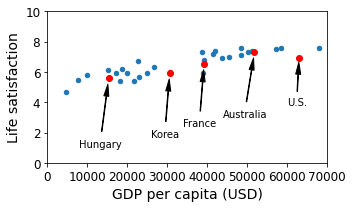

In [41]:
# 7개 국가를 제외한 국가들의 데이터 산점도
sample_data.plot(kind='scatter', x="GDP per capita 2020", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 70000, 0, 10])

# 언급된 5개 국가명 명기 좌표
position_text = {
    "Hungary": (8000, 1),
    "Korea": (26000, 1.7),
    "France": (34000, 2.4),
    "Australia": (44000, 3.0),
    "United States": (60000, 3.8),
}

# 5개 국가는 좌표를 이용하여 빨강색 점으로 표기
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    # 5개 국가명 표기
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    # 5개 국가 산점도 그리기
    plt.plot(pos_data_x, pos_data_y, "ro")
plt.xlabel("GDP per capita (USD)")
save_fig('money_happy_scatterplot')
plt.show()

언급된 5개 국가의 1인당 GDP와 삶의 만족도를 데이터에서 직접 확인하면 다음과 같다.

In [42]:
sample_data.loc[list(position_text.keys())]

,GDP per capita 2020,Life satisfaction
Country,,
Hungary,15372.885,5.6
Korea,30644.427,5.9
France,39257.434,6.5
Australia,51885.466,7.3
United States,63051.398,6.9


# **선형 관계**

위 산점도에 따르면 1인당 GDP와 삶의 만족도가 어느 정도 선형 관계에 있는 것처럼 보인다. 아래 도표에서 그려진 세 개의 직선 중에서 파랑색 실선이 선형 관계를 가장 적절하게 나타낸다.

Saving figure tweaking_model_params_plot


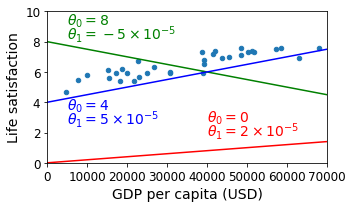

In [84]:
import numpy as np

sample_data.plot(kind='scatter', x="GDP per capita 2020", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 70000, 0, 10])
X=np.linspace(0, 70000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")
save_fig('tweaking_model_params_plot')
plt.show()

# **선형회귀 모델 훈련**

선형 관계는 위 도표에서처럼 직선으로 구현되는 선형회귀 모델(linear regression model)은 직선의 절편(Y축과 만나는 점)과 기울기 두 개의 모델 파라미터(model parameters)에 의해 결정된다.

In [44]:
from sklearn import linear_model

# 선형회귀 모델 지정
lin1 = linear_model.LinearRegression()

# 훈련 데이터셋 지정
Xsample = np.c_[sample_data["GDP per capita 2020"]]
ysample = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
lin1.fit(Xsample, ysample)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

훈련된 모델이 알아낸 최적 선형 모델의 절편과 기울기는 아래 두 속성에 저장된다.

*   intercept_[0]: 직선의 절편
*   coef_[0]: 직선의 기울기

In [47]:
# 예측된 최적의 직선에 대한 정보: 절편과 기울기
t0, t1 = lin1.intercept_[0], lin1.coef_[0][0]

t0, t1

(5.071121853750363, 4.1410177424136694e-05)

Saving figure best_fit_model_plot


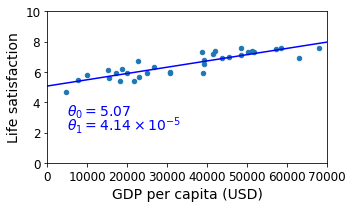

In [52]:
# 산점도
sample_data.plot(kind='scatter', x="GDP per capita 2020", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 70000, 0, 10])

# 직선 그리기
X=np.linspace(0, 70000, 1000)
plt.plot(X, t0 + t1*X, "b")
# 직선의 절편과 기울기 정보 명시
plt.text(5000, 3.1, r"$\theta_0 = 5.07$", fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = 4.14 \times 10^{-5}$", fontsize=14, color="b")

save_fig('best_fit_model_plot')
plt.show()

**훈련된 모델 활용**

훈련된 모델을 이용하여 한 국가의 삶의 만족도를 1인당 GDP를 이용하여 예측한다. 예를 들어, 키프러스(Cyprus) 1인당 GDP만 다음과 같이 알려져 있을 때 키프러스 국민의 삶의 만족도를 예측한다.

*   키프러스 1인당 GDP : 26240


In [78]:
cyprus_gdp_per_capita = gdp_per_capita_2020.loc["Cyprus"]["GDP per capita 2020"]
print(cyprus_gdp_per_capita)

26240.048


훈련된 모델의 predict() 메서드를 이용하면 키프러스 국민의 삶의 만족도는 6.15 정도로 예측된다.

In [79]:
cyprus_predicted_life_satisfaction = lin1.predict([[cyprus_gdp_per_capita]])[0][0]
cyprus_predicted_life_satisfaction

6.157726897048226

예측값과 직선 확인

Saving figure cyprus_prediction_plot


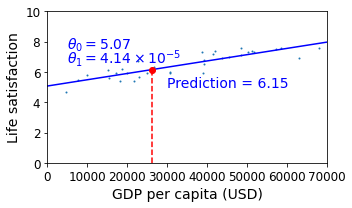

In [83]:
sample_data.plot(kind='scatter', x="GDP per capita 2020", y='Life satisfaction', figsize=(5,3), s=1)
plt.xlabel("GDP per capita (USD)")

# 예측된 최적의 직선
X=np.linspace(0, 70000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.axis([0, 70000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 5.07$", fontsize=14, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.14 \times 10^{-5}$", fontsize=14, color="b")

# 키프러스에 대한 삶의 만족도 예측값

# 빨간 점선 그리기
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(30000, 5.0, r"Prediction = 6.15", fontsize=14, color="b")

# 예측 지점 좌표 찍기(빨강생)
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")
save_fig('cyprus_prediction_plot')
plt.show()

**대표성 없는 훈련 데이터**


In [57]:
missing_data

,GDP per capita 2020,Life satisfaction
Country,,
Colombia,5207.238,6.3
Brazil,6450.451,6.4
Mexico,8069.104,6.5
Chile,12612.322,6.5
Ireland,79668.502,7.0
Switzerland,81867.462,7.5
Luxembourg,109602.322,6.9


7개 국가를 포함한 전체 훈련 데이터셋을 이용하여 훈련한 결과를 7개 국가를 제외했을 때의 훈련 결과와 비교한다.

*   검정 실선: 7개 국가 포함 예측 선형 모델
*   파랑 점선: 7개 국가 제외 예측 선형 모델



In [107]:
position_text2 = {
    "Colombia": (1000, 9.0),
    "Brazil": (10000, 8.0),
    "Mexico": (20000, 9.0),
    "Chile": (32000, 9.0),
    "Ireland": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

Saving figure representative_training_data_scatterplot


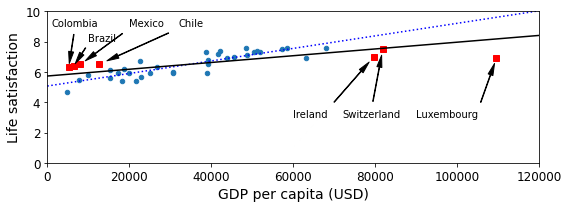

In [108]:
# 7개 국가를 제외한 국가들의 산점도 (파랑색 점)
sample_data.plot(kind='scatter', x="GDP per capita 2020", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 120000, 0, 10])

# 7개 국가 산점도(빨강 점)
for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    # 7개 국가명 표기
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

# 7개 국가 제외 예측 선형 모델 그래프 (파랑 점선)
X=np.linspace(0, 120000, 1000)
plt.plot(X, t0 + t1*X, "b:")

# 7개 국가 포함 선형회귀 모델 훈련 및 예측
lin_reg_full = linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita 2020"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

# 7개 국가 포함 예측 선형 모델 그래프(검정 실선)
t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 120000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

save_fig('representative_training_data_scatterplot')
plt.show()

**결론:** 선형회귀 모델은 1인당 GDP와 삶의 만족도 사이의 관계를 모델링 하기에 부적합하다.

Saving figure ridge_model_plot


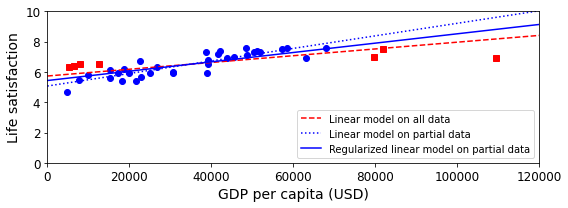

In [97]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

# 7개 국가 제외 데이터 산점도(파랑 동그라미)
plt.plot(list(sample_data["GDP per capita 2020"]), list(sample_data["Life satisfaction"]), "bo")
# 제외된 7개 국가 산점도(빨강 네모)
plt.plot(list(missing_data["GDP per capita 2020"]), list(missing_data["Life satisfaction"]), "rs")

# 7개 국가 포함 예측 선형 모델 그래프(빨강 파선)
X = np.linspace(0, 120000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
# 7개 국가 제외 예측 선형 모델 그래프(파랑 점선)
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

# 릿지(Ridge) 규제 적용 훈련: 7개 국가 제외 데이터 대상
ridge = linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita 2020"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
# 릿지 규제 적용 예측 선형 모델 그래프(파랑 실선)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 120000, 0, 10])
plt.xlabel("GDP per capita (USD)")
save_fig('ridge_model_plot')
plt.show()

# **k- 최근접 이웃 회귀**

키프러스의 키프러스의 삶의 만족도를 사례 기반 학습으로 예측하기 위해 1인당 GDP가 키프러스의 경우가 가장 가까운 국가들의 삶의 만족도의 평균값을 활용할 수 있다.

예를 들어, 키프러스의 1인당 GDP와 가장 가까운 세 나라는 다음과 같다 

키프러스 = 26240

*   에스토니아 (Estonia)
*   슬로베니아 (Slovenia)
*   스페인 (Spain)

In [113]:
sample_data[11:14]

,GDP per capita 2020,Life satisfaction
Country,,
Estonia,22985.858,5.7
Slovenia,25038.792,5.9
Spain,26831.629,6.3


위 세 나라의 삶의 만족도의 평균값은 다음과 같다.

In [111]:
(5.7+5.9+6.3)/3

5.966666666666668

사이킷런에서 지원하는 k-최근접 이웃 회귀모델을 적용하면 동일한 결과를 얻게 된다

*   n_neighbors = 3: 예측할 데이터와 가장 가까운 3개의 훈련 데이터 정보를 활용한다는 의미임.

In [114]:
import sklearn.neighbors
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

In [115]:
X = np.c_[sample_data["GDP per capita 2020"]]
y = np.c_[sample_data["Life satisfaction"]]

# 모델 훈련
model.fit(X, y)

# 키프러스 국가에 대한 예측하기
X_new = np.array([[26240.048]])  # 키프러스' GDP per capita
print(model.predict(X_new)) 

[[5.96666667]]
